<a href="https://colab.research.google.com/github/priyampnchl/image-to-waveform/blob/main/source/Hilbert_Sight_to_sound_64x64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demo - Sight to sound application

Takes in a 64x64 image and turns it into an audio waveform.

The idea behind this project is to focus more on the applicability of infinite math such as hilbert curves, and particularly to explore the properties of fractal geometries. The project highlights how the self repeating nature and the property of spatial proximity preservation of Hilbert Curves leads to an interesting and unique result that is otherwise not possible to achieve.

###Usage
Run cell 1 and upload the image that is included in the "test.jpg" image included in the same directory as this notebook. Each successive cell can be run one by one to see what each cell is doing.

###Note:
The runtime crashes sometimes when executing the final cell, but it should be fine if retried.

1. This cell imports the file using the google.colab files.upload() function

In [ ]:
from google.colab import files
uploaded = files.upload() #upload file

Saving test.jpg to test (1).jpg


2. This cell installs and imports required libraries (see code comments) and defines an array normalizing function. 

In [ ]:
!pip install hilbertcurve                             #installs the hilbertcurve library on runtime

#Import necessary packages
from hilbertcurve.hilbertcurve import HilbertCurve
from numpy import asarray                             #for array functions 
import numpy as np                                    #for array functions
import math                                           #for math functions
import cv2                                            #for image functions
import matplotlib.pyplot as plt                       #for plotting
from scipy.io.wavfile import write                    #for creating the waveform

def normalize(values, bounds):                        #Define a normalize function for array 
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


3. This cell creates an image object "input_img" and displays the image "test.jpg", which would be the uploaded image. 

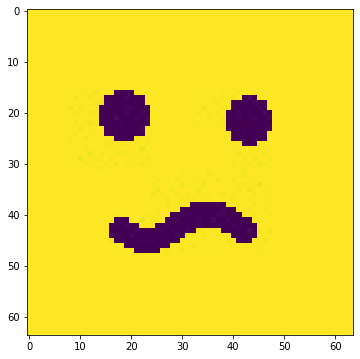

In [ ]:
input_img = cv2.imread('test.jpg',0) #creates an image object using the filename provided (in this case, test.jpg, must match uploaded file)
plt.figure(figsize=(6,6)) #defines size of the rendered plot 
plt.imshow(input_img) #renders the image uploaded

4. This cell defines the parameters of the Hilbert Curve that we need to generate. The number of pixels in the image correspond to the total length and therefore the total number of points on the Hilbert Curve. 

  The dimension of the Hilbert Curve is 2 (because, planar). The total is given by line 3 in the code below, (order (64*64) which must equal 4096, so the order of the hilbert curve is 6.

In [ ]:
p=6                                   #Order of the Hilbert Curve
n=2                                   #Dimension  of the Hilbert Curve (here 2, for planar curve)
total=(n**p)**2                       #total number of points in Hilbert Curve, should be same as pixels in the image 
img_dimension=int(math.sqrt(total))   #Will determine how many freq components are there

5. This cell creates a hilbert curve object using the set parameters and the library command, and plots the 6th order 2D hilbert curve on the left. The right side shows how the different points in the 2D space are mapped to a linear range from 0 to 4096, from (0,0) to (64,64). 

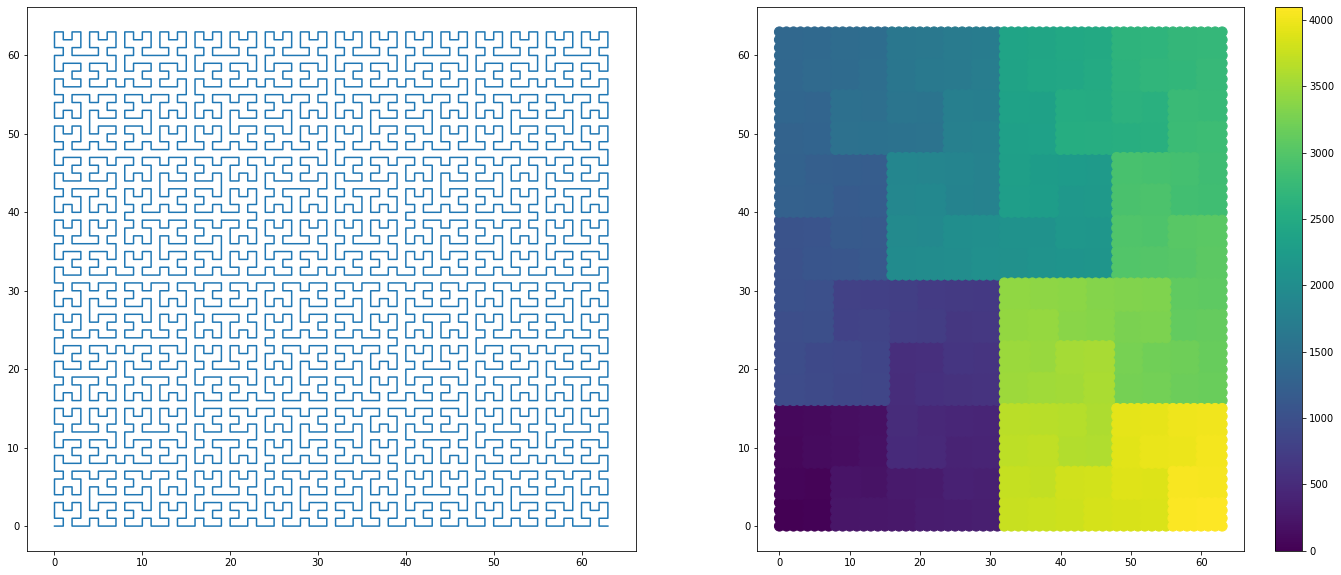

In [ ]:
hilbert_curve = HilbertCurve(p, n)                      #Create a HilbertCurve object
distances = list(range(total))                          #Create array of distances along HilbertCurve
points = hilbert_curve.points_from_distances(distances) #Array of x,y coordinates for [i]th element on Hilbert Curve
x_coords, y_coords = zip(*points)                       #Split array into x coord array and y coord array

plt.figure(figsize=(24,10))
plt.subplot(121)
plt.plot(x_coords, y_coords)                            #Plot Hilbert Curve

c = distances
plt.subplot(122)
plot=plt.scatter(x_coords, y_coords, c=c, s=100)        #Plot colormapped Hilbert Curve
cbar = plt.colorbar(plot)                               #Plot Colorbar

6. This block is to resize the image, because as will become evident in the later steps, the frequency resolution is actually very difficult with 4096 separate values. 

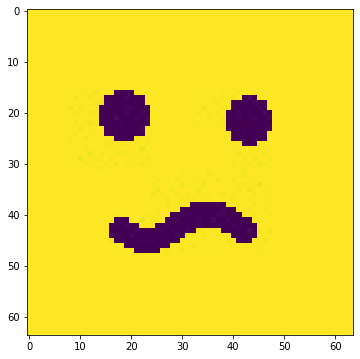

In [ ]:
#Resize block, only comes into picture when we want to reduce resolution to allow better frequency separation at the cost of losing resolution 
#Right now though, this block is not doing any resizing.
resized_img = cv2.resize(input_img, dsize=(img_dimension, img_dimension))  
plt.figure(figsize=(6,6))
plt.imshow(resized_img)

7. This cell creates the  array that has the pixel values mapped to the image using the Hilbert Curve and plots the intensity values of the pixels as transformed onto the 1 dimensional line

<BarContainer object of 4096 artists>

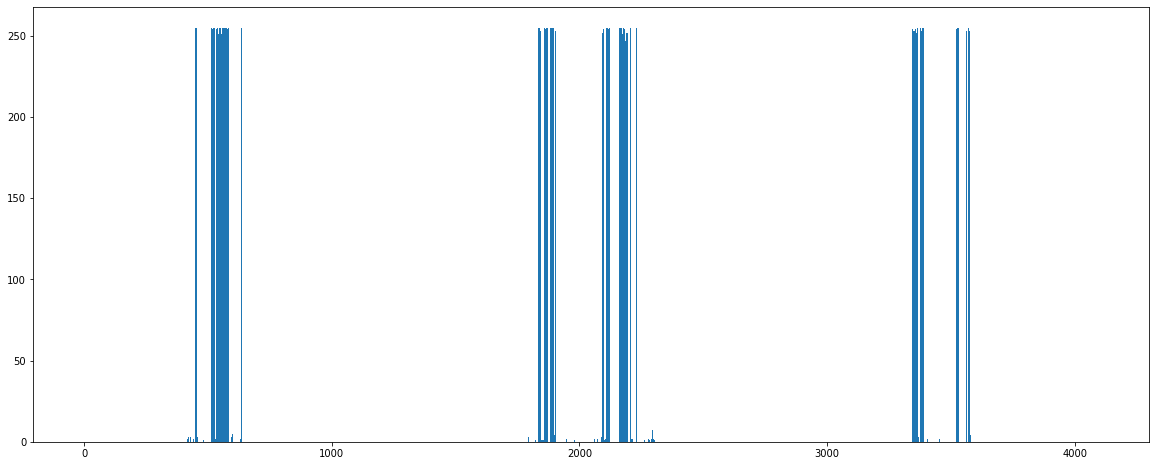

In [ ]:
inv_img=cv2.bitwise_not(resized_img)                    #Inverting the image because we are using black lines on white background, so this will make black correspond to high inentsity and white to low. 
hilbert_array=np.zeros(total)                           #Create empty array full of Zeroes

#Create a 1D array and populate the pixel values onto it using hilbert coordinate mapping 
for i in range(total):
  hilbert_array[i]=inv_img[points[i][0]][points[i][1]]  #Iterating through the empry array and populating the components in it based on the image values

plt.figure(figsize=(20,8))
plt.bar(range(total),hilbert_array)

8. This block creates a list of equidistant frequency components between 2 specified points (min and max)

<BarContainer object of 4096 artists>

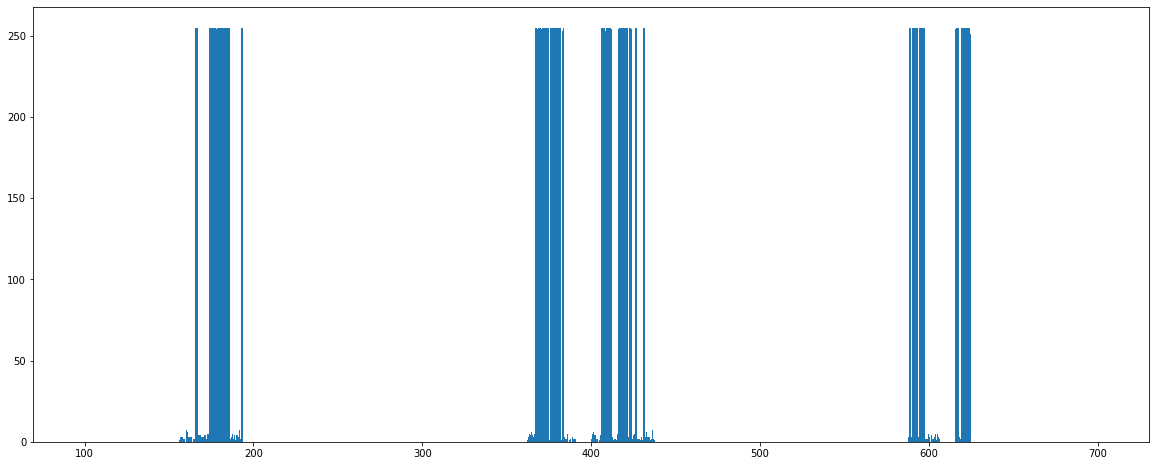

In [ ]:
start=100           #Lower bound frequency
stop=700            #Upper bound frequency 
num_points=total
eqpoints = np.linspace(start, stop, num_points) #Array of equally spaced points


for i in range(total):
  eqpoints[i]=round(eqpoints[i],6) 

freqs_intensities=dict(zip(eqpoints,hilbert_array))
plt.figure(figsize=(20,8))

plt.bar(eqpoints,hilbert_array) #This plot shows the intensities of each frequency component in the final waveform

9. This cell defines a function that generates a sinewave of a set length (seconds) at 44.1KHz sample rate at a specified frequency. 

    **This code has been taken from the documentation. Link is here.** https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html 

array([ 0.00000000e+00,  4.66861226e+00,  9.33722443e+00, ...,
       -9.33722443e+00, -4.66861226e+00, -8.02560033e-12])

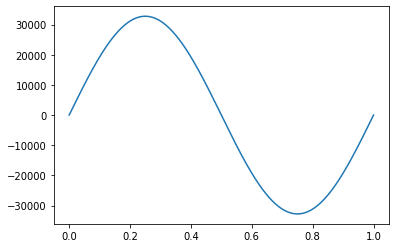

In [ ]:
samplerate = 44100
def gen_sinewave(freq,scaling=1):
  t = np.linspace(0., 1., samplerate)
  amplitude = np.iinfo(np.int16).max
  data = amplitude * scaling * np.sin(2. * np.pi * freq * t)
  plt.plot(t,data)
  return data

gen_sinewave(1)

10. This cell will take the array of intensities at each frequency and creates a waveform combining all the different sinewaves.

    **The code to write a wav file here has been taken from the documentation. Link is here.** https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html

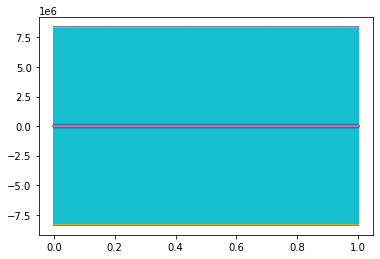

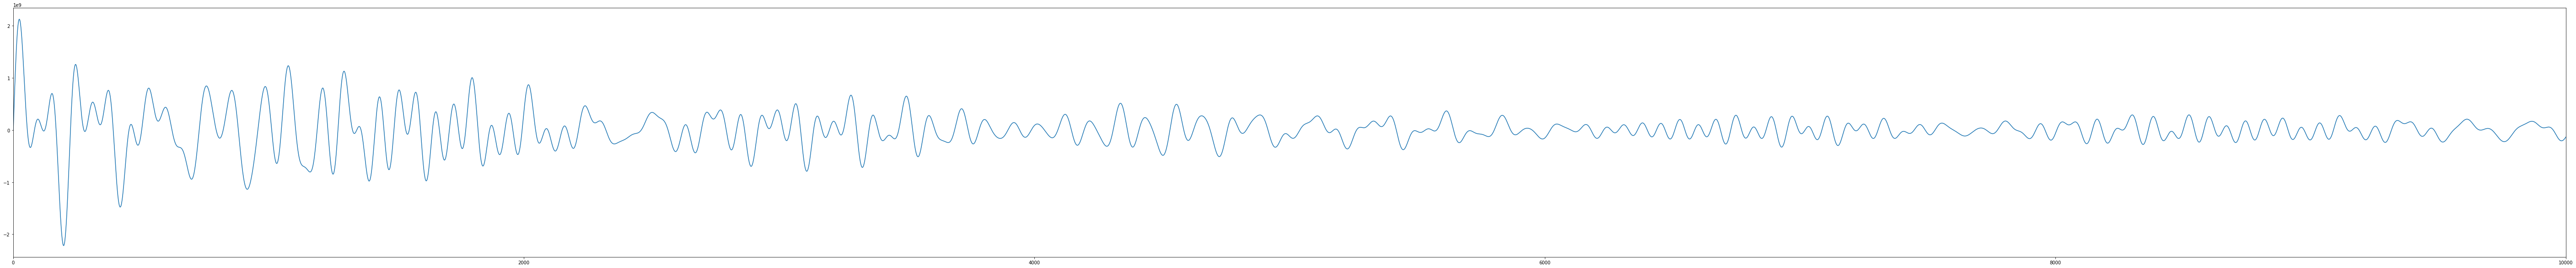

In [ ]:
t=0.1
bsin=gen_sinewave(0,0)
for i in range(total):                                        #Cumulate all sinewaves together
  sin=gen_sinewave(eqpoints[i],hilbert_array[i]) #Generate sinewave corresponding to i'th frequency
  bsin=np.add(sin,bsin)                                       #Add sinewave to the previous
plt.figure(figsize=(100,10))
plt.xlim([0,10000])                                           #X-axis limit on graph for visualisation
plt.plot(bsin)
write("test_result.wav", samplerate, bsin.astype(np.int16))      #Write the .wav file